In [1]:
import pandas as pd 
import numpy as np 
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# import zigzag
import plotly.express as px
import plotly.graph_objects as go

# Get BTC Data 15 min

In [2]:
df = pd.read_csv("BTC_Close.csv", index_col=0)
df.index = pd.to_datetime(df.index, unit='ms')

data = df.resample('15T').last().fillna(method='ffill')

# Zigzag 源码

In [3]:
"""
reference:
https://github.com/jbn/ZigZag.git
"""
import numpy as np

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK


def peak_valley_pivots(X, up_thresh, down_thresh):
    """
    Find the peaks and valleys of a series.

    :param X: the series to analyze
    :param up_thresh: minimum relative change necessary to define a peak
    :param down_thesh: minimum relative change necessary to define a valley
    :return: an array with 0 indicating no pivot and -1 and 1 indicating
        valley and peak


    The First and Last Elements
    ---------------------------
    The first and last elements are guaranteed to be annotated as peak or
    valley even if the segments formed do not have the necessary relative
    changes. This is a tradeoff between technical correctness and the
    propensity to make mistakes in data analysis. The possible mistake is
    ignoring data outside the fully realized segments, which may bias
    analysis.
    """
    if down_thresh > 0:
        raise ValueError('The down_thresh must be negative.')

    initial_pivot = identify_initial_pivot(X, up_thresh, down_thresh)
    t_n = len(X)
    pivots = np.zeros(t_n, dtype=np.int_)
    trend = -initial_pivot
    last_pivot_t = 0
    last_pivot_x = X[0]

    pivots[0] = initial_pivot

    # Adding one to the relative change thresholds saves operations. Instead
    # of computing relative change at each point as x_j / x_i - 1, it is
    # computed as x_j / x_1. Then, this value is compared to the threshold + 1.
    # This saves (t_n - 1) subtractions.
    up_thresh += 1
    down_thresh += 1

    for t in range(1, t_n):
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh:
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh:
                pivots[last_pivot_t] = trend
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t

    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势

    return pivots


def max_drawdown(X):
    """
    Compute the maximum drawdown of some sequence.

    :return: 0 if the sequence is strictly increasing.
        otherwise the abs value of the maximum drawdown
        of sequence X
    """
    mdd = 0
    peak = X[0]

    for x in X:
        if x > peak:
            peak = x

        dd = (peak - x) / peak

        if dd > mdd:
            mdd = dd

    return mdd if mdd != 0.0 else 0.0


def pivots_to_modes(pivots):
    """
    Translate pivots into trend modes.

    :param pivots: the result of calling ``peak_valley_pivots``
    :return: numpy array of trend modes. That is, between (VALLEY, PEAK] it
    is 1 and between (PEAK, VALLEY] it is -1.
    """

    modes = np.zeros(len(pivots), dtype=np.int_)
    mode = -pivots[0]

    modes[0] = pivots[0]

    for t in range(1, len(pivots)):
        x = pivots[t]
        if x != 0:
            modes[t] = mode
            mode = -x
        else:
            modes[t] = mode

    return modes


def compute_segment_returns(X, pivots):
    """
    :return: numpy array of the pivot-to-pivot returns for each segment."""
    pivot_points = np.array(X[pivots != 0])
    return pivot_points[1:] / pivot_points[:-1] - 1.0

## 精简版源码

In [4]:
import zigzag

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK

# 结合做多做空

In [31]:
def backtest_both(X, rise, down, take_profit_long=10, take_profit_short=0, output=True, mode=0, ma_array=None, ma_window=0):
    """_summary_

    Args:
        X (_type_): _description_
        rise (_type_): _description_
        down (_type_): _description_
        take_profit_long (int, optional): _description_. Defaults to 10.
        take_profit_short (int, optional): _description_. Defaults to 0.
        output (bool, optional): _description_. Defaults to True.
        mode (int, optional): 0 for both, 1 for long, 2 for short. Defaults to 0. 
        ma_array (_type_, optional): _description_. Defaults to None.
        ma_window (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    allowance = 1 # 每次交易允许买1个比特币，请勿修改，若修改得改变后面收益率计算方式
    cash = 0 # 初始化资金
    shares_long = 0 # 初始化多头持仓
    shares_short = 0 # 初始化空头持仓
    low = high = None # 初始化最高价和最低价
    n = len(X) # 数据长度
    cash_array = np.zeros(n) # 初始化资金数组
    shares_long_array = np.zeros(n) # 初始化多头持仓数组
    shares_short_array = np.zeros(n) # 初始化空头持仓数组
    actions_long = np.zeros(n) # 初始化多头仓位变化数组
    actions_short = np.zeros(n) # 初始化空头仓位变化数组
    cum_returns = np.zeros(n) # 初始化累计收益数组
    up_thresh, down_thresh = rise, down # 设置上涨下跌阈值
    last_buy = 1000000 # 初始化上一次买入价格
    last_sell = 1000000 # 初始化上一次卖出价格
    last_price = 0 # 初始化上一次价格
    
    # 回测
    for t in range(n):
        # 第一天找到初始趋势，高点和低点
        if t == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            last_price = X[t]
            continue
        
        
        x = X[t] # 当前价格
        r = x / last_pivot_x # 当前价格与上一个最高点/最低点的比例

        # 判断趋势，高点，低点
        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
            
        p = X[t] # 当前价格
        ma_level = ma_array[t] if ma_array is not None and not np.isnan(ma_array[t]) else 0 # 当前均线
            
        if low is None or high is None: # 确保已经有了low high再开始交易
            continue
        
        ## 计算收益率
        cur_return = 0 
        if shares_long > 0:        
            cur_return += (p - last_price) / last_buy # 多头今天变化的收益率
        if shares_short < 0:
            cur_return += (last_price - p) / last_sell # 空头今天变化的收益率
        # 当前累计收益率 = 累计到昨天收益率 + 今天变化的收益率
        cum_returns[t] = cur_return + cum_returns[t - 1]
        last_price = p # 更新上一次价格
        
        if mode >= 0 and (p < low) and shares_long > 0: # 如果当前价格小于谷底，并且有持仓，则卖出止损
            # 平仓止损
            # cash += shares_long * p
            cash += shares_long * low
            if output: print("止损", p, X.index[t], "盈亏", p - last_buy)
            shares_long = 0
            actions_long[t] = 2 # 卖出止损
            # last_sell = p
        
        # if (p > take_profit_long * last_buy) and shares > 0: # 如果当前价格大于买入价格的止盈，并且有持仓，则卖出止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = 3
        #     last_sell = p
        
        if mode <= 0 and (p > high) and shares_short < 0: # 如果当前价格大于顶点，并且有做空持仓，则买入止损
            # 平仓止损
            # cash += shares_short * p
            cash += shares_short * high
            if output: print("止损", p, X.index[t], "盈亏", last_sell - p)
            shares_short = 0
            actions_short[t] = -2 # 买入止损
            # last_buy = p


            
        
        # if (p < take_profit_short * last_sell) and shares < 0: # 如果当前价格小于卖出价格的止盈，并且有做空，则买入止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = -3
        #     last_buy = p
        
        if mode >= 0 and p > high and shares_long == 0 and (ma_level == 0 or p > ma_level): # 如果当前价格大于顶点，并且没有持仓，则做多
            # 做多
            shares_long = allowance
            # cash -= shares_long * p
            cash -= shares_long * high
            if output: print("做多", p, X.index[t])
            actions_long[t] = 1
            last_buy = p
        
        if mode <= 0 and p < low and shares_short == 0 and (ma_level == 0 or p < ma_level): # 如果当前价格小于谷底，并且没有持仓，则做空
            # 做空
            shares_short = -allowance
            # cash -= shares_short * p
            cash -= shares_short * low
            if output: print("做空", p, X.index[t])
            actions_short[t] = -1
            last_sell = p
            
            
        if t == len(pivots) - 1: # 最后时刻清仓
            cash += (shares_short + shares_long) * p
            shares_short = shares_long = 0
        
        cash_array[t] = cash
        shares_long_array[t] = shares_long
        shares_short_array[t] = shares_short
    
    shares_array = shares_long_array + shares_short_array
    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "actions_long": actions_long, "actions_short": actions_short, "price": X, "pivots": pivots})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    df_pnl["cum_return"] = cum_returns
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["cum_return"].diff().fillna(0)
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    annual_freq = freq / 60 / 24 / 365
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"] # 只计算入场的时刻的收益率
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * annual_freq
        total_return = df_pnl["cum_return"][-1]
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() / np.sqrt(annual_freq)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        cummaxs = np.where(df_pnl["cum_return"] == df_pnl["cum_return"].cummax())[0]
        max_loss_period = max(np.diff(cummaxs).max(), len(df_pnl) - cummaxs[-1]) * annual_freq
        stats = dict(rise=rise, down=down, freq=freq, ma_window=ma_window, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, max_loss_period=max_loss_period, hold_time=time_length,  start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, stats

## 参数1

,rise,down,freq,ma_window,total_return,yearly_vol,maxdrawdown,sharpe,max_loss_period,hold_time,start_date,end_date
0,0.05,-0.04,30.0,50,2.429222,0.680396,0.547016,1.873593,0.421975,1.905594,2020-01-01,2022-07-31


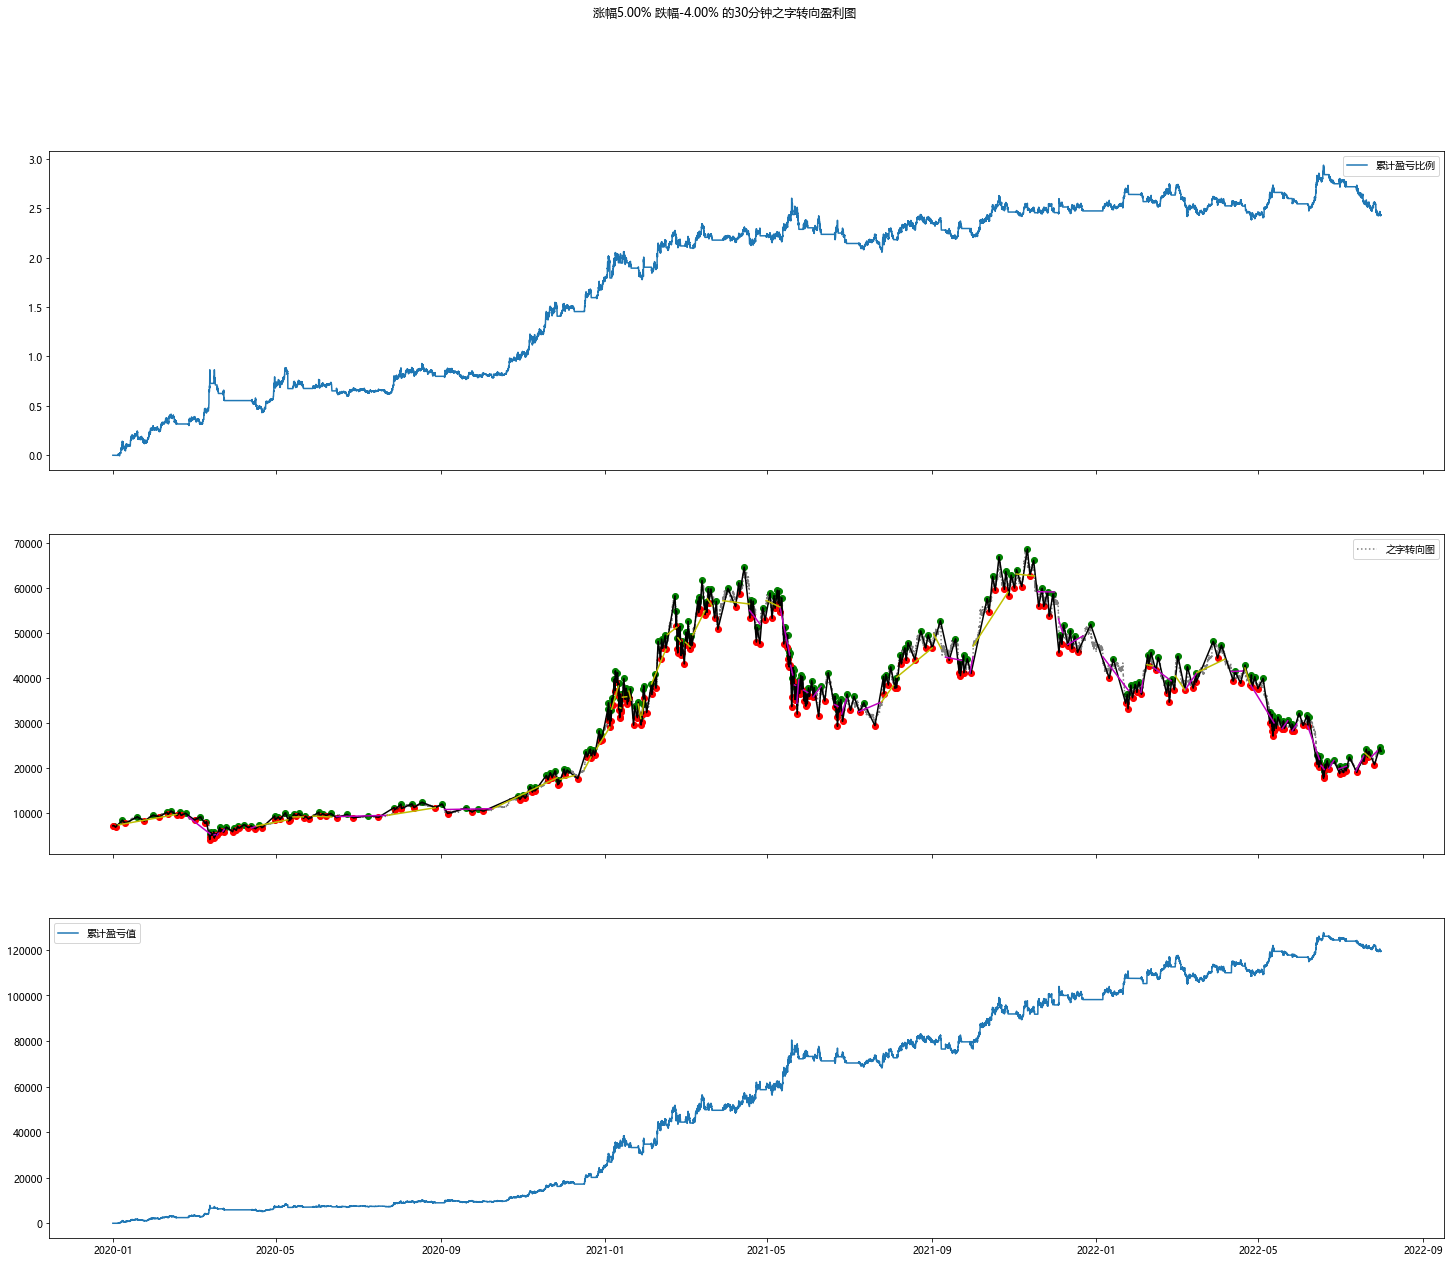

In [33]:
freq = 30
rise = 0.05
down = -0.04
take_profit_long, take_profit_short = 1, 0.9
ma_window = 50
start_date = "2020"
end_date = "2022"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma_array = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma_array = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma_array=ma_array, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])

## 参数2

,rise,down,freq,ma_window,total_return,yearly_vol,maxdrawdown,sharpe,max_loss_period,hold_time,start_date,end_date
0,0.055,-0.06,30.0,50,3.040719,0.699589,0.524813,2.201237,0.408733,1.974543,2020-01-01,2022-07-31


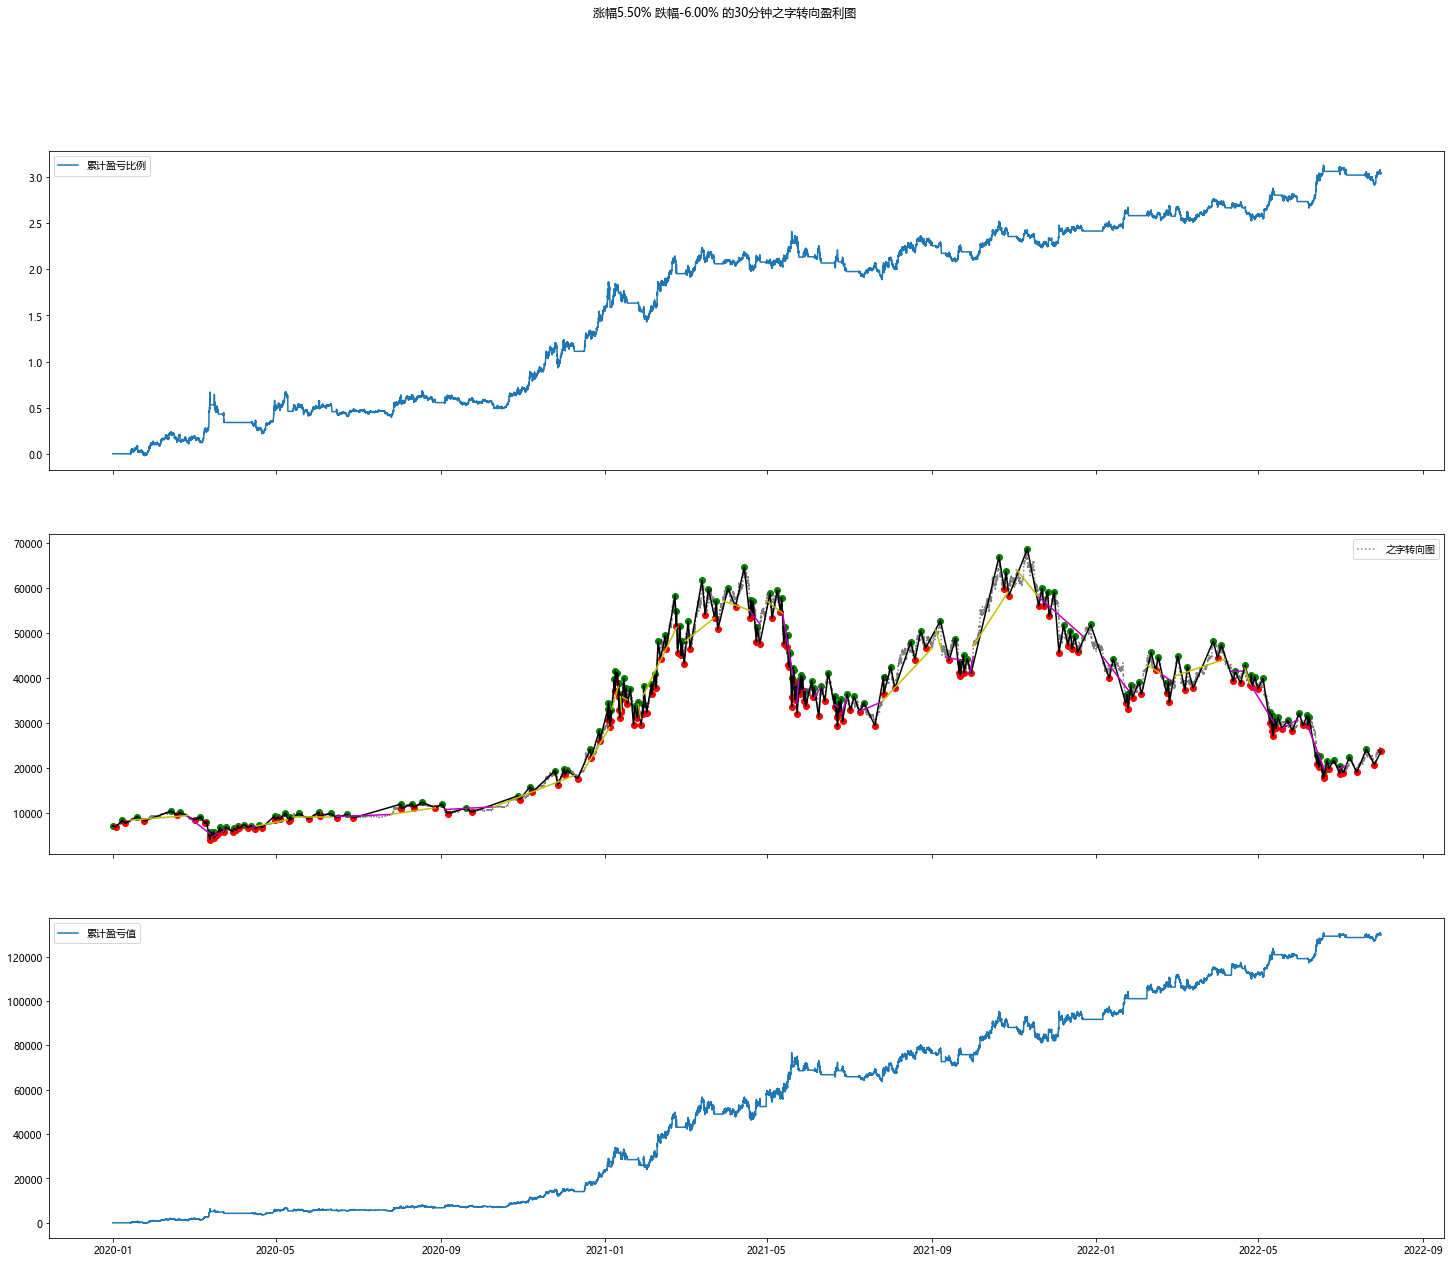

In [35]:
rise = 0.055
down = -0.06
freq = 30
ma_window = 50
take_profit_long, take_profit_short = 1, 0.9
start_date = "2020"
end_date = "2022"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma_array = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma_array = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma_array=ma_array, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])

## 参数3

,rise,down,freq,ma_window,total_return,yearly_vol,maxdrawdown,sharpe,max_loss_period,hold_time,start_date,end_date
0,0.035,-0.07,30.0,50,1.104078,0.770992,0.4168,1.937676,0.181735,0.739041,2021-01-01,2021-12-31


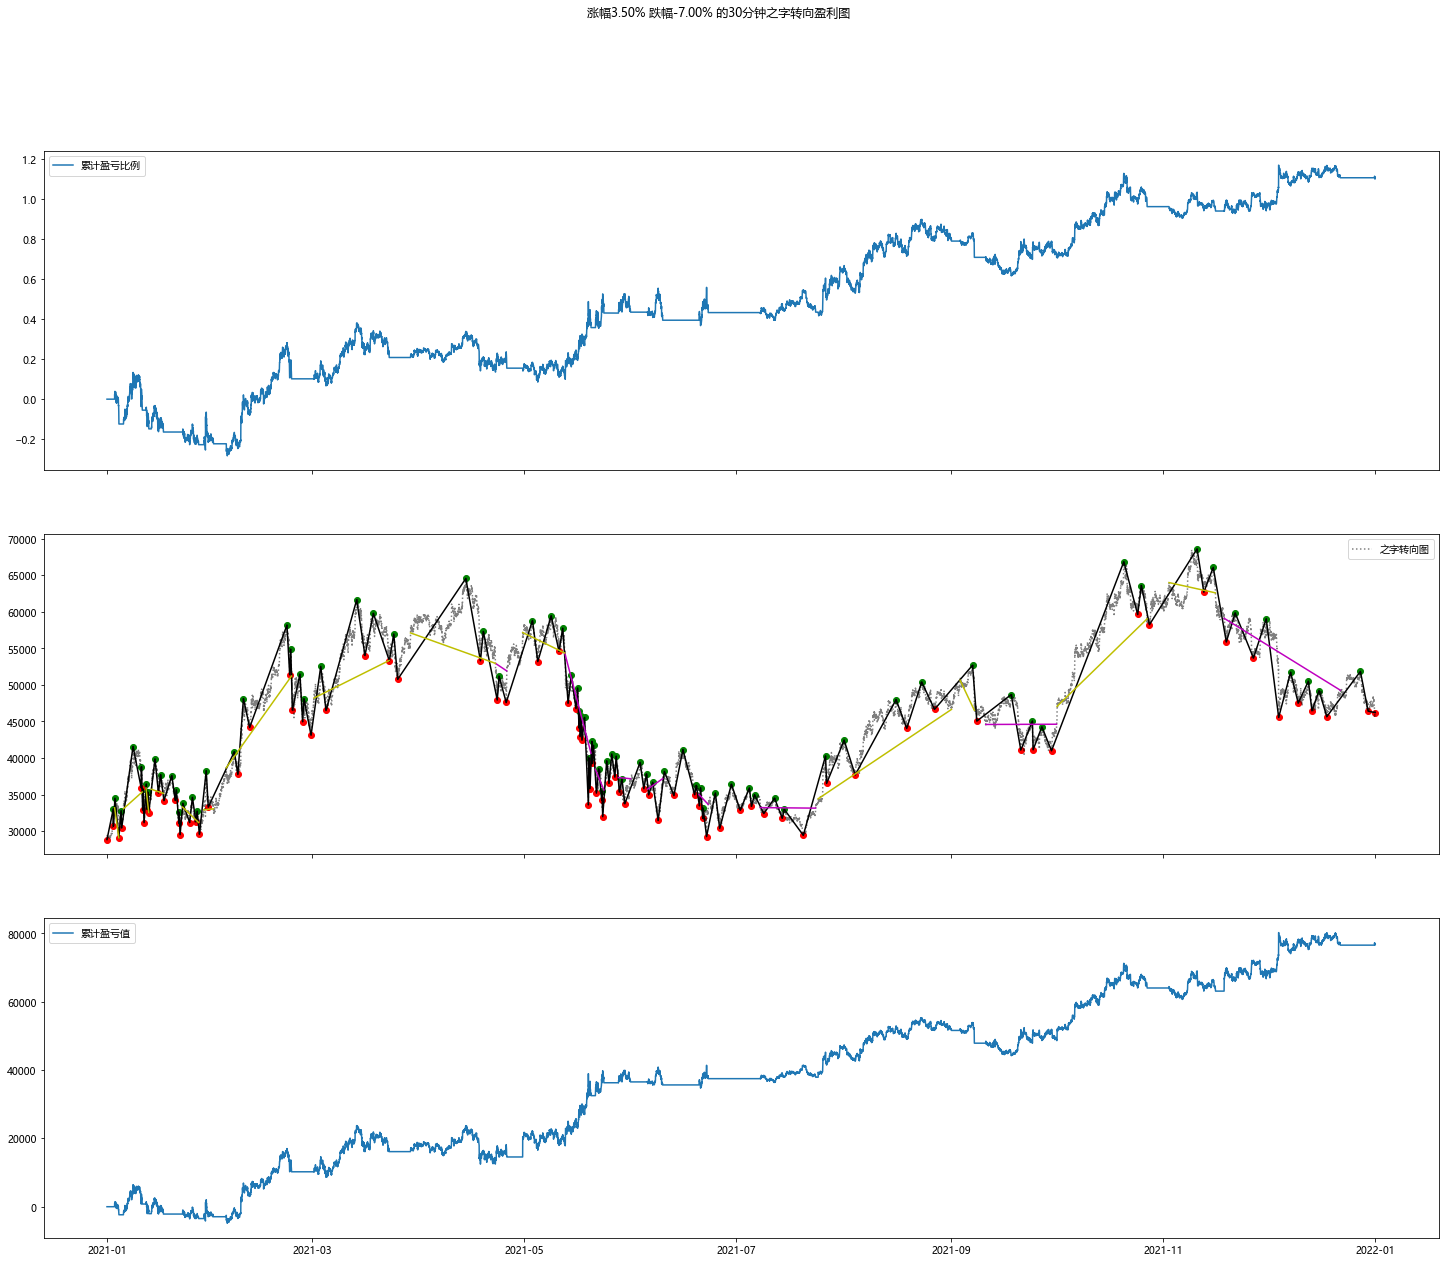

In [40]:
rise = 0.035
down = -0.07
freq = 30
ma_window = 50
take_profit_long, take_profit_short = 1, 0.9
start_date = "2021"
end_date = "2021"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma_array = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma_array = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma_array=ma_array, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])